In [1]:
from sklearn import tree
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/data_processed.csv')

## Preprocess
Convert string columns to categorial codes

In [3]:
string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)

In [4]:
candidate_cols = [
     'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
     'num_hh_travelers',
     'num_travelers',
     'o_location_type',
     'd_location_type',
     'o_congestion',
     'd_congestion',
     'age',
     'employment',
     'student',
     'license',
     'planning_apps',
     'industry',
     'gender',
     'education',
     'survey_language',
     'num_bicycles',
     'num_vehicles',
     'res_type',
     'rent_own',
     'income_aggregate',
     'num_people',
     'num_adults',
     'num_kids',
     'num_workers',
     'num_students',
     'disability'
]

## Use decision tree to regress trip distance

In [5]:
X = df[candidate_cols].to_numpy()
y = df['trip_distance'].to_numpy()
group = df['person_id'].to_numpy()

In [6]:
# Use small subset of data to see if it can overfit.
# X = X[:10000]
# y = y[:10000]
# group = group[:10000]

From the output of the following cell, we can see that the result are not good. The mean square error is still 

In [7]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from numpy import mean, absolute

def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)


k_fold = GroupKFold(n_splits=5)

mse = [] # [(training_mse, validation_mse, variance)]
mae = [] # [(training_mae, validation_mae, mean_avearge_deviation)]

for train_idx, validate_idx in k_fold.split(X, y, groups=group):
    print(f'train size: {len(train_idx)}, validation size: {len(validate_idx)}')
    
    # test linear regression
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    model = DecisionTreeRegressor(min_samples_leaf=250).fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    print('training mse / validation mse / variance: {:.2f} / {:.2f} / {:.2f}'.format(
        mean_squared_error(y_pred_train, y_train),
        mean_squared_error(y_pred_val, y_val),
        np.var(y_val)
    ))
    
    mse.append([
        mean_squared_error(y_pred_train, y_train),
        mean_squared_error(y_pred_val, y_val),
        np.var(y_val)
    ])
    
    
    print('training mse / validation mae / median absolute deviation:{:.2f} / {:.2f} / {:.2f}'.format(
        mean_absolute_error(y_pred_train, y_train),
        mean_absolute_error(y_pred_val, y_val),
        mad(y_val)
    ))
    
    mae.append([
         mean_absolute_error(y_pred_train, y_train),
        mean_absolute_error(y_pred_val, y_val),
        mad(y_val)
    ])
    
    print('')

pd.DataFrame(np.concatenate((mse, mae), axis=1),
             columns=['training mse', 'validation mse', 'variance of ground truth', 'training mae', 'validation_mae', 'mean absolute deviation'])

train size: 31555, validation size: 7889
training mse / validation mse / variance: 10.72 / 12.27 / 14.52
training mse / validation mae / median absolute deviation:2.21 / 2.32 / 2.75

train size: 31555, validation size: 7889
training mse / validation mse / variance: 11.22 / 10.50 / 12.03
training mse / validation mae / median absolute deviation:2.27 / 2.27 / 2.46

train size: 31555, validation size: 7889
training mse / validation mse / variance: 10.81 / 12.04 / 13.54
training mse / validation mae / median absolute deviation:2.23 / 2.34 / 2.63

train size: 31555, validation size: 7889
training mse / validation mse / variance: 10.99 / 11.27 / 13.22
training mse / validation mae / median absolute deviation:2.24 / 2.27 / 2.63

train size: 31556, validation size: 7888
training mse / validation mse / variance: 11.02 / 11.23 / 12.32
training mse / validation mae / median absolute deviation:2.25 / 2.33 / 2.46



,training mse,validation mse,variance of ground truth,training mae,validation_mae,mean absolute deviation
0,10.723320,12.274294,14.524555,2.209215,2.320603,2.752595
1,11.218908,10.497303,12.032250,2.265144,2.266236,2.458236
2,10.814520,12.039402,13.543735,2.225807,2.340153,2.630016
3,10.993547,11.271226,13.219250,2.237388,2.271622,2.631272
4,11.018907,11.225532,12.318988,2.254419,2.330593,2.462284


The results are not good. It does not perform significantly better than the variance of the ground truth (note: the variance would be the mse for a model outputting the mean value for every input)

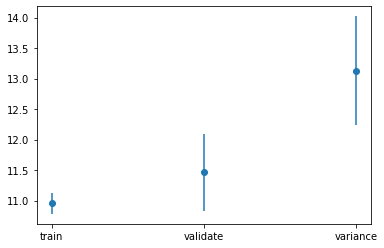

In [306]:
import matplotlib.pyplot as plt

mse_avg = np.average(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.xticks([0, 1, 2], ['train', 'validate', 'variance'])
plt.errorbar([0, 1, 2], mse_avg, yerr=mse_std, linestyle='None', marker='o')
plt.show()

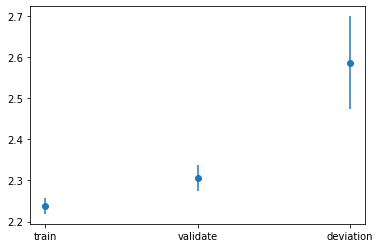

In [307]:
import matplotlib.pyplot as plt

mae_avg = np.average(np.array(mae), axis=0)
mae_std = np.std(np.array(mae), axis=0)
plt.xticks([0, 1, 2], ['train', 'validate', 'deviation'])
plt.errorbar([0, 1, 2], mae_avg, yerr=mae_std, linestyle='None', marker='o')
plt.show()

### Apply decision tree classifier to classify trip length
Let's try with a decision tree classifier.

In [12]:
# important_cols = ['d_congestion', 'd_purpose_category', 'num_vehicles', 'res_type', 'o_purpose_category',
#                   'income_aggregate']
X = df[candidate_cols].to_numpy()
y = df['trip_distance_category'].to_numpy()
group = df['person_id'].to_numpy()

In [21]:
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

k_fold = GroupKFold(n_splits=5)

for i, (train_idx, validate_idx) in enumerate(k_fold.split(X, y, groups=group)):
    print(f'train size: {len(train_idx)}, validation size: {len(validate_idx)}')
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    
    model = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    print('training/validation precision: {:.2f} / {:.2f}'.format(
        precision_score(y_pred_train, y_train, average='micro'),
        precision_score(y_pred_val, y_val, average='micro'),
    ))
    
    labels = ['short', 'medium', 'long']
    confusion = confusion_matrix(y_val, y_pred_val, labels=labels, normalize='pred')
    confusion_df = pd.DataFrame(confusion, index=[x + '-label' for x in labels], columns=[x + '-pred' for x in labels])
    print('confusion matrix')
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(confusion_df)
#     with np.printoptions(precision=2, suppress=True):
#         print(confusion)
    
#     if i == 0:
#         plt.figure()
#         tree.plot_tree(model)
#         plt.savefig('tree.eps',format='eps',bbox_inches = "tight")

    
    print('')


train size: 31555, validation size: 7889
training/validation precision: 0.48 / 0.48
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.48         0.26       0.11
medium-label        0.33         0.43       0.28
long-label          0.18         0.31       0.61

train size: 31555, validation size: 7889
training/validation precision: 0.48 / 0.49
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.51         0.27       0.15
medium-label        0.32         0.43       0.28
long-label          0.17         0.30       0.57

train size: 31555, validation size: 7889
training/validation precision: 0.48 / 0.47
confusion matrix
              short-pred  medium-pred  long-pred
short-label         0.49         0.31       0.16
medium-label        0.33         0.39       0.25
long-label          0.18         0.30       0.58

train size: 31555, validation size: 7889
training/validation precision: 0.49 / 0.45
confusion matrix
     

### Apply decision tree to classify mode choice

In [22]:
X = df[candidate_cols].to_numpy()
y = df['mode'].to_numpy()

In [28]:
TRANSPORT_MODES = ['drive', 'passenger', 'bus', 'subway', 'bike', 'walk', 'other']

k_fold = GroupKFold(n_splits=5)

confusion = None
for i, (train_idx, validate_idx) in enumerate(k_fold.split(X, y, groups=group)):
    print(f'train size: {len(train_idx)}, validation size: {len(validate_idx)}')
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    
    model = DecisionTreeClassifier(min_samples_leaf=200).fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    print('training/validation precision: {:.2f} / {:.2f}'.format(
        precision_score(y_pred_train, y_train, average='micro'),
        precision_score(y_pred_val, y_val, average='micro'),
    ))
    
    if i == 0:
        confusion = confusion_matrix(y_val, y_pred_val, labels=TRANSPORT_MODES, normalize='pred')
    
    
#     if i == 0:
#         plt.figure()
#         tree.plot_tree(model)
#         plt.savefig('tree.eps',format='eps',bbox_inches = "tight")

    
    print('')
    
confusion_df = pd.DataFrame(confusion, index=[x + '-label' for x in TRANSPORT_MODES],
                            columns=TRANSPORT_MODES)

print('row is ground truth, column is prediction\n')
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(confusion_df)

train size: 31555, validation size: 7889
training/validation precision: 0.59 / 0.57

train size: 31555, validation size: 7889
training/validation precision: 0.59 / 0.56

train size: 31555, validation size: 7889
training/validation precision: 0.58 / 0.58

train size: 31555, validation size: 7889
training/validation precision: 0.60 / 0.53

train size: 31556, validation size: 7888
training/validation precision: 0.59 / 0.56

row is ground truth, column is prediction

                 drive  passenger  bus  subway  bike  walk  other
drive-label       0.63       0.16 0.03    0.07  0.00  0.14   0.00
passenger-label   0.15       0.36 0.00    0.03  0.00  0.05   0.00
bus-label         0.01       0.03 0.33    0.14  0.00  0.06   0.00
subway-label      0.03       0.05 0.31    0.43  0.00  0.14   0.00
bike-label        0.00       0.01 0.00    0.03  0.00  0.02   0.00
walk-label        0.16       0.36 0.33    0.27  0.00  0.56   0.00
other-label       0.01       0.03 0.00    0.04  0.00  0.02   0.00
